# Remove Video Background with DeepLabV3 & TorchVision

In [2]:
import cv2
import torch
import torchvision.transforms as transforms
from torchvision.models.segmentation import deeplabv3_resnet101
import numpy as np
from IPython.display import display, clear_output
from PIL import Image
import matplotlib.pyplot as plt

## Load the DeepLabV3 model pre-trained on COCO.

In [2]:
model = deeplabv3_resnet101(pretrained=True)
model.eval()  # Set the model to evaluation mode

/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Preprocessing

In [3]:
def preprocess_frame(frame):
    """Preprocess the frame for model inference."""
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((520, 520)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(frame).unsqueeze(0)

## Generate Segmentation Mask

In [ ]:
def generate_mask(model, frame):
    """Generate a segmentation mask for the frame."""
    input_tensor = preprocess_frame(frame)
    with torch.no_grad():
        output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0)
    mask = output_predictions.byte().cpu().numpy()
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

    # Binarize the mask (without this, the foreground will be semi-transparent)
    _, mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)
    mask = mask.astype('uint8')  # Ensure mask is in CV_8U format
    return mask

## Composite Foreground and New Background

In [5]:
def composite_frame(frame, mask, new_background):
    """Composite the foreground from the frame onto the new background."""
    # Resize the new background to match the frame size
    new_background = cv2.resize(new_background, (frame.shape[1], frame.shape[0]))

    # Extract the foreground using the mask
    foreground = cv2.bitwise_and(frame, frame, mask=mask)

    # Extract the background from the new background
    background_mask = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(new_background, new_background, mask=background_mask)

    # Combine the foreground and new background
    result = cv2.add(foreground, background)
    return result

## Process a Single Frame

In [6]:
def process_frame(frame, model, new_background):
    """Process a single frame: remove background and add new background."""
    mask = generate_mask(model, frame)
    return composite_frame(frame, mask, new_background)

## Load New Background

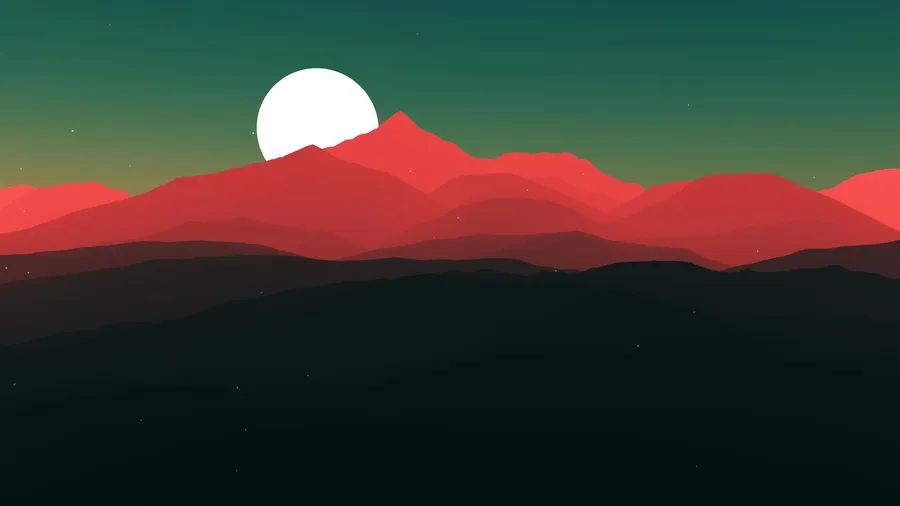

In [ ]:
new_background_path = "assets/moon-retro-vector-art-7op8fanjrtajdzp0.jpg"  
new_background = cv2.imread(new_background_path)

if new_background is None:
    raise ValueError("Could not load background image.")

# Display the new background
display(Image.fromarray(cv2.cvtColor(new_background, cv2.COLOR_BGR2RGB)))

## Process the video

### Option 1: Use Progress Bar

In [ ]:
from tqdm import tqdm

# Input video path
input_video = "assets/background_test_set_1.mp4"  

# Open the video file
cap = cv2.VideoCapture(input_video)
if not cap.isOpened():
    raise ValueError("Could not open video.")

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
output_video = "assets/background_removed_1_ipynb.mp4"  
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for _ in tqdm(range(total_frames), desc="Processing Video"):
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame
    result = process_frame(frame, model, new_background)

    # Write the frame to the output video
    out.write(result)

print("Processing complete. Output saved to:", output_video)

Processing Video:  99%|█████████▉| 1115/1127 [24:09<00:15,  1.30s/it]

Processing complete. Output saved to: assets/background_removed_1_ipynb.mp4


### Option 2: Display progress frame by frame

In [ ]:
# Input video path
input_video = "assets/background_test_set_1.mp4" 

# Open the video file
cap = cv2.VideoCapture(input_video)
if not cap.isOpened():
    raise ValueError("Could not open video.")

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
output_video = "assets/background_removed_1.mp4"  
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Process the video frame by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame
    result = process_frame(frame, model, new_background)

    # Write the frame to the output video
    out.write(result)

    # Display the frame in the notebook
    clear_output(wait=True)
    display(Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB)))

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

print("Video processing complete. Output saved to:", output_video)

In [6]:
output_video = "assets/background_removed_1.mp4"  

## Bonus: Plot the screenshot 

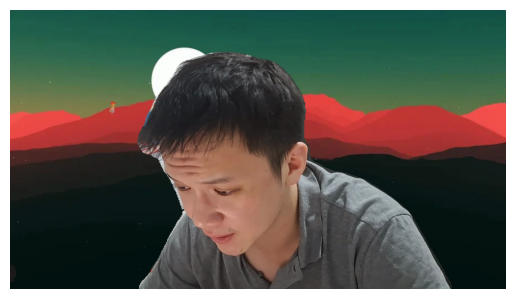

In [7]:
def show_screenshot(video_path, frame_number=0):
    """Capture and display a frame from the processed video."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError("Could not open video file.")

    # Set the frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()
    if not ret:
        raise ValueError("Could not read frame.")

    # Convert the frame from BGR to RGB for display
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display the frame using matplotlib
    plt.imshow(frame_rgb)
    plt.axis('off')  # Hide axes
    #plt.title(f"Frame {frame_number} from Processed Video")
    plt.show()

    # Release the video capture object
    cap.release()

# Call the function to show a screenshot
show_screenshot(output_video, frame_number=150)  # Display the 150th frame